In [1]:

! git clone https://github.com/ultralytics/yolov8


Cloning into 'yolov8'...
Username for 'https://github.com': ^C


In [3]:
! pip install -qr yolov8/requirements.txt


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'yolov8/requirements.txt'


In [4]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 kB 17.7 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install clearml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.6 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
import torch
#from yolo8  import utils
from ultralytics.models import YOLO
import torch
from IPython import display
from IPython.display import clear_output
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import io
import os
import cv2
import json
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

%matplotlib inline

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [8]:
IMAGES_PATH = "/kaggle/input/birdies/images"
LABELS_PATH = "/kaggle/input/birdies/labels"
#NOTES_PATH = "/kaggle/input/birdies/labels"

In [11]:
labels = os.listdir(LABELS_PATH)

# Split data
train, test = train_test_split(labels, test_size=0.15, shuffle=True)
valid, test = train_test_split(test, test_size=0.2)

print(f"train: {len(train)}; valid: {len(valid)}; test: {len(test)}")

train: 1708; valid: 241; test: 61


In [9]:

os.makedirs("test/images")
os.makedirs("test/labels")
os.makedirs("train/images")
os.makedirs("train/labels")
os.makedirs("valid/images")
os.makedirs("valid/labels")


In [13]:
def move_files_to_dir(files, dirname):
    for label_filename in files:
        image_filename = f"{label_filename[:-4]}.jpg"
        shutil.copy(f"{IMAGES_PATH}/{image_filename}", f"{dirname}/images/{image_filename}")
        shutil.copy(f"{LABELS_PATH}/{label_filename}", f"{dirname}/labels/{label_filename}")

# Move splits to folders
move_files_to_dir(train, "train")
move_files_to_dir(test, "test")
move_files_to_dir(valid, "valid")

In [16]:
train_path = "../train/images"
test_path = "../test/images"
valid_path = "../valid/images"

In [14]:
descr_darknet = json.load(open(NOTES_PATH))

train_path = "../train/images"
test_path = "../test/images"
valid_path = "../valid/images"

nc = len(descr_darknet["categories"])
names = [category["name"] for category in descr_darknet["categories"]]

print(
    f"train: {train_path}\n"
    f"test: {test_path}\n"
    f"val: {valid_path}\n\n"
    f"nc: {nc}\n"
    f"names: {names}",
)

NameError: name 'NOTES_PATH' is not defined

In [18]:
with open("data.yaml", "w") as file:
    yaml.dump({
        "train": train_path,
        "test": test_path,
        "val": valid_path,
        #"nc": nc,
        #"names": [f'{name}' for name in names]
    }, stream=file, default_flow_style=None)

print("Now we are ready to train yolov5 model")
! ls 

Now we are ready to train yolov5 model
data.yaml  test  train	valid


In [2]:
img_size = (224, 224, 3) 
bach_size = 128 
img_dir = r'/kaggle/input/birdies/images'
label_dir = r'/kaggle/input/birdies/labels'
working_dir = r'/kaggle/working/'
test_dir = r'/kaggle/input/birdies/test images'

In [4]:
def get_box(label_dir, img_size): \
    # оптимизировано для диапазона чисел не более 2^16
    with open(label_dir) as f: # открытие файлов в ириктории
        line=f.readline()    
    box_params = line.split() # разделяем числа по пробелу
    xc = np.float16(box_params[1]) * img_size[1] # центр картинки по x
    yc = np.float16(box_params[2]) * img_size[0]   # центр картинки по y 
    
    bw = np.float16(box_params[3]) * img_size[1] # ширина
    bh = np.float16(box_params[4]) * img_size[0] # высота

    # отрисовка линий ящика
    x_min = np.int16((xc - bw/2)) # отложим от центра половину ширины вправо и влево
    
    x_max = np.int16((xc + bw/2))
    y_min = np.int16((yc - bh/2)) # отложим от центра половину длины вправо и влево
    
    y_max = np.int16((yc + bh/2))
    
    return x_min, y_min, x_max, y_max

# 

In [5]:
get_box(label_dir + '/0010.txt', img_size)

(67, 20, 155, 217)

## Отрисуем ящики на картинках

In [6]:
# Подготовка путей и данных
img_list = np.sort(os.listdir(img_dir))
label_list = np.sort(os.listdir(label_dir))
zip_list = zip(img_list, label_list) # генератор


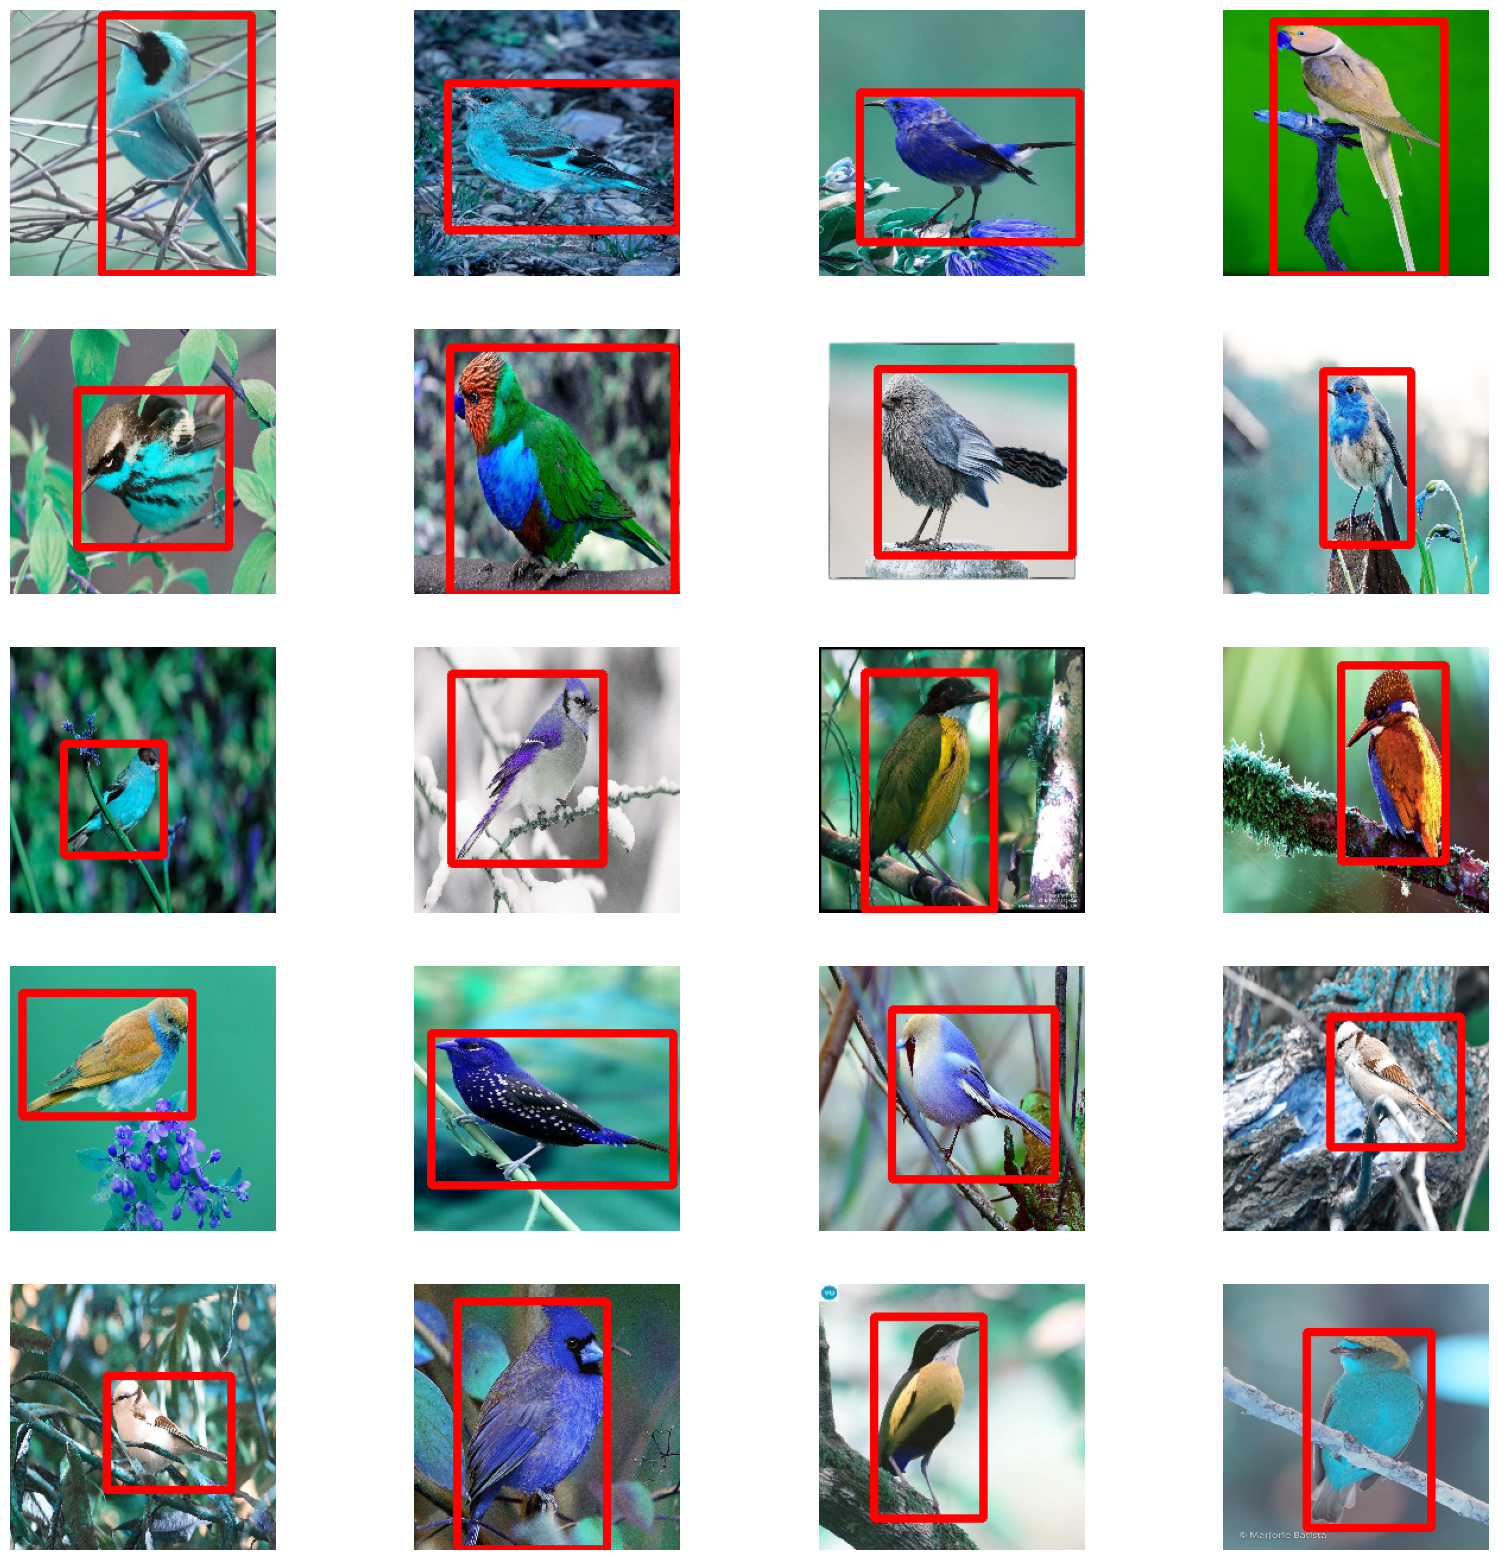

In [9]:
plt.figure(figsize=(20,20))
i=0
for img, box in zip_list:
    img_path = os.path.join(img_dir, img) # соеденяем в путь к конкретной картинки
    label_path = os.path.join(label_dir, box) # получаем путь ящика
    img_draw = cv2.imread(img_path)
    img_draw = cv2.resize(img_draw, img_size[:2])
    xmin, ymin, xmax, ymax = get_box(label_path, img_size)      
        
    cv2.rectangle(img_draw, (xmin, ymin), (xmax, ymax), (255,0,0), 6) # рисуем прямоугольник на картинки
    plt.subplot(5,4, i+1)
    plt.axis('off')
    plt.imshow(img_draw)
    i += 1
 
    if i >= 20:
        break
plt.show()

In [11]:
%time
def make_data(img_list, label_list, img_dir,label_dir, img_size):
    zip_list = zip(img_list, label_list)
    boxes = []
    images = []
    i = 1
    count = len(img_list)
    for img, label in zip_list:
        msg = f'processing image {i} of  {count}'
        i += 1
        print(msg, '\r', end='')
        img_path = os.path.join(img_dir, img)
        labelpath = os.path.join(label_dir, label)
        img_read = cv2.imread(img_path)
        img_read = cv2.resize(img_read, img_size[:2])
        xmin, ymin, xmax, ymax= get_box(label_path, img_size)  
        box = [xmin, ymin, xmax, ymax] 
        
        images.append(img_read)
        boxes.append(box)
    
    images = np.array(images)
    boxes =  np.array(boxes)
    return images, boxes

images, boxes = make_data(img_list, label_list, img_dir,label_dir, img_size)
X_train, X_test, y_train, y_test = train_test_split(images, boxes, train_size=.7, shuffle=True, random_state=142)  

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.78 µs


## EfficientNetB1

In [ ]:
from ultralytics import YOLO
 
# Load the model.
model = YOLO('yolov8n.pt')
 
# Training.
results = model.train(
   data='custom_data.yaml',
   imgsz=640,
   epochs=10,
   batch=8,
   name='yolov8n_custom')

In [15]:
lr = .0005

base = tf.keras.applications.efficientnet.EfficientNetB1(
    include_top=False, weights="imagenet",input_shape=img_size, pooling='avg')

base.trainable = True
x = base.output

x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x = Dropout(rate=0.33, seed=123)(x)       
output = Dense(4, activation='linear')(x)


model = Model(inputs = base.input, outputs = output)

model.compile(RMSprop(learning_rate=lr), loss='mse', metrics=['accuracy']) 